# Example 1

> This example will demonstrate a TEF analysis carried out for the Persian Gulf using data from Lorenz et al. (2020).
> 

In [1]:
from TotalExchangeFlow.tef_core import *
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
ds_winter = xr.open_dataset("./Programs/TotalExchangeFlow/data/SoH_2_2011_01.nc") #exchange flow in Strait of Hormuz winter
ds_summer = xr.open_dataset("./Programs/TotalExchangeFlow/data/SoH_2_2011_01.nc") #exchange flow in Strait of Hormuz summer
ds_2d_winter = xr.open_dataset("./Programs/TotalExchangeFlow/data/Surface_2011_01.nc") #SST and SSS winter
ds_2d_summer = xr.open_dataset("./Programs/TotalExchangeFlow/data/Surface_2011_08.nc") #SST and SSS summer

To get an overview about the area and the model domain, we first plot the Sea Surface Temperature (SST) and Sea Surface Salinity (SSS) during winter and summer (one daily mean value).

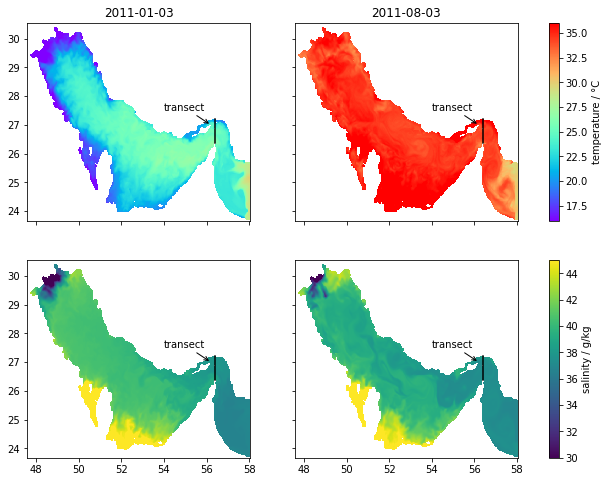

In [3]:
fig, ax = plt.subplots(2,2,sharex=True,sharey=True,figsize=(11,8))
ax=ax.ravel()
ax[0].set_title(str(ds_2d_winter.time[0].values)[:10])
ax[1].set_title(str(ds_2d_summer.time[0].values)[:10])
ax[0].pcolormesh(ds_2d_winter.lonc,ds_2d_winter.latc,ds_2d_winter.temp[0,0,:,:],vmin=16,vmax=36,cmap='rainbow')
tmp = ax[1].pcolormesh(ds_2d_summer.lonc,ds_2d_summer.latc,ds_2d_summer.temp[0,0,:,:],vmin=16,vmax=36,cmap='rainbow')
ax[2].pcolormesh(ds_2d_winter.lonc,ds_2d_winter.latc,ds_2d_winter.salt[0,0,:,:],vmin=30,vmax=45)
sal = ax[3].pcolormesh(ds_2d_summer.lonc,ds_2d_summer.latc,ds_2d_summer.salt[0,0,:,:],vmin=30,vmax=45)
plt.colorbar(tmp,ax=ax[:2],label='temperature / °C')
plt.colorbar(sal,ax=ax[2:],label='salinity / g/kg')
for axx in ax:
    axx.annotate('transect',xy=(56.2,27.),xytext=(54,27.5),arrowprops=dict(arrowstyle='->'))
    axx.plot([ds_winter.lonc.values,ds_winter.lonc.values],[ds_winter.latc.values[0],ds_winter.latc.values[-1]],color='k')

One can see that the Persian Gulf shows a large seasonal cycle in SST, varying from below 16°C in January to 
values greater than 36°C in August. The salinity shows regional differences with the Shatt Al Arab river plume in the north west and greatest surface salinities in the south.
Now let's explore the exchange flow. 

In [4]:
tef = TEF_object(ds = ds_winter)
tef.set_up()

**Note**: Minus sign for velx3d since negative velocities flow into the Glf and should be therefore counted as an inflow which is defined as positive!
**Note**: Calculation will around 3 minutes.

In [5]:
tef.calc_volume_transport(-tef.ds.velx3d, tef.ds.hn, tef.ds.dyc) 
tef.salt_transport = -tef.ds.salt*tef.ds.velx3d*tef.ds.hn*tef.ds.dyc
tef.temp_transport = -tef.ds.temp*tef.ds.velx3d*tef.ds.hn*tef.ds.dyc

out1d_vol_transport_s  = tef.sort_1dim(sort_by_variable=tef.ds.salt,
                       transport = tef.volume_transport,
                       N = 100, minmaxrange=(36,41))

out1d_salt_transport_s = tef.sort_1dim(sort_by_variable=tef.ds.salt,
                       transport = tef.salt_transport,
                       N = 100, minmaxrange=(36,41))

out1d_vol_transport_t  = tef.sort_1dim(sort_by_variable=tef.ds.temp,
                       transport = tef.volume_transport,
                       N = 100, minmaxrange = (18,36))

out1d_temp_transport_t = tef.sort_1dim(sort_by_variable=tef.ds.temp,
                       transport = tef.temp_transport,
                       N = 100, minmaxrange = (18,36))

out2d = tef.sort_2dim(sort_by_variable=tef.ds.temp, #first variable will be y axis
                      sort_by_variable2=tef.ds.salt, #second variable will be x axis
                      transport = tef.volume_transport,
                      N = 100, minmaxrange = (18,36), minmaxrange2=(36,41))

Let's first have a look a the January 2011 mean results:

In [6]:
q_2d_mean = out2d.q2.mean('time')
q_s = out1d_vol_transport_s.q.mean('time')
q_t = out1d_vol_transport_t.q.mean('time')

Q_s = out1d_vol_transport_s.Q.mean('time')
Q_t = out1d_vol_transport_t.Q.mean('time')

Qs_s = out1d_salt_transport_s.Q.mean('time')
Qt_t = out1d_temp_transport_t.Q.mean('time')

bulk_vol_s = tef.calc_bulk_values(out1d_vol_transport_s.var_Q,Q_s)
bulk_vol_t = tef.calc_bulk_values(out1d_vol_transport_t.var_Q,Q_t)

#using the index option to be faster and to exactly use the dividing values from before to avoid problems,
#if the automatic Q_thresh would give different values!
bulk_salt_s = tef.calc_bulk_values(out1d_salt_transport_s.var_Q,Qs_s,index=bulk_vol_s.index)
bulk_temp_t = tef.calc_bulk_values(out1d_temp_transport_t.var_Q,Qt_t,index=bulk_vol_t.index)

print('Q_in: {} m3s-1 and Q_out {} m3s-1 from the isohaline TEF, Q_net: {} m3s-1'
      .format(bulk_vol_s.Qin.values[0],bulk_vol_s.Qout.values[0],bulk_vol_s.Qin.values[0]+bulk_vol_s.Qout.values[0]))
print('Q_in: {} m3s-1 and Q_out {} m3s-1 from the isothermal TEF, Q_net: {} m3s-1'
      .format(bulk_vol_t.Qin.values[0],bulk_vol_t.Qout.values[0],bulk_vol_t.Qin.values[0]+bulk_vol_t.Qout.values[0]))

s_in  = bulk_salt_s.Qin / bulk_vol_s.Qin
s_out = bulk_salt_s.Qout / bulk_vol_s.Qout

t_in  = bulk_temp_t.Qin / bulk_vol_t.Qin
t_out  = bulk_temp_t.Qout / bulk_vol_t.Qout

print('s_in: {} g/kg and s_out: {} g/kg'.format(s_in.values[0],s_out.values[0]))
print('t_in: {} °C and t_out: {} °C'.format(t_in.values[0],t_out.values[0]))

Q_in: 235064.74767548358 m3s-1 and Q_out -170513.31682439466 m3s-1 from the isohaline TEF, Q_net: 64551.430851088924 m3s-1
Q_in: 174325.13388143503 m3s-1 and Q_out -109773.70303034606 m3s-1 from the isothermal TEF, Q_net: 64551.43085108897 m3s-1
s_in: 37.20742124239829 g/kg and s_out: 39.480090726688125 g/kg
t_in: 24.849464538176267 °C and t_out: 26.759366270173903 °C


The reason why the volume transports from the isohaline and the isothermal TEF analysis are different lies in the partial compensation in the different axis when integrating back to 1D:

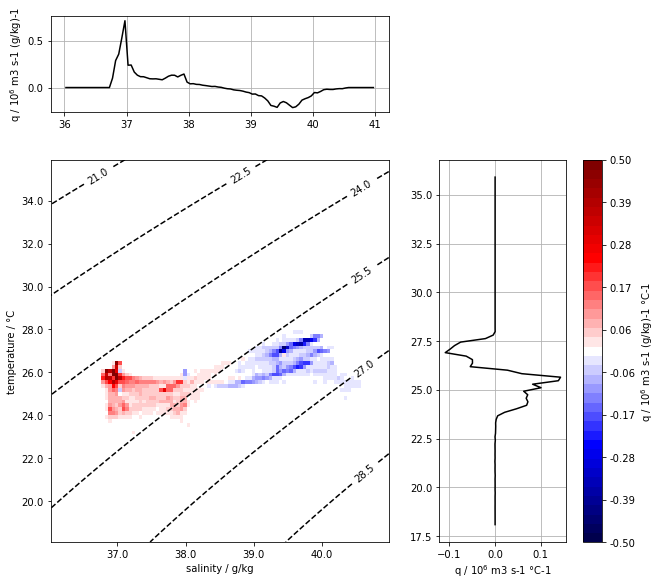

In [7]:
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
import gsw as gsw

##first compute density with the Gibbs Sea Water package based on TEOS10
ydim=np.shape(out2d.var_q)[0]
xdim=np.shape(out2d.var_q2)[0]

dens = np.zeros(shape=(xdim,ydim))
for i in range(0,int(xdim)):
    #print(i)    
    dens[:,i]=gsw.rho(out2d.var_q2[i],out2d.var_q,0) #0 pressure since the model uses potential temperature
dens = dens - 1000.0


vmax=0.5

fig = plt.figure()
gs = gridspec.GridSpec(2, 2,width_ratios=[2, 1],height_ratios=[1, 4])

ax1 = plt.subplot(gs[0])#top left
ax2 = plt.subplot(gs[1])#top right
ax3 = plt.subplot(gs[2])#bottom left (main panel)
ax4 = plt.subplot(gs[3])#bottom right
fig.set_size_inches(10,10)

#plot the T-S TEF in main panel with density contours
pcol = ax3.pcolor(out2d.var_q2, out2d.var_q, out2d.q2.mean('time')/1000000., cmap=plt.cm.get_cmap('seismic', 41),vmin=-vmax,vmax=vmax)
cont = ax3.contour(out2d.var_q2, out2d.var_q, dens, linestyles='dashed', colors='k')
plt.clabel(cont, fontsize=10, inline=1, fmt='%1.1f')
ax3.tick_params('both', colors='black')
ax3.set_xlabel('salinity / g/kg')
ax3.set_ylabel('temperature / °C')
ax3.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
v = np.linspace(-vmax, vmax, 10, endpoint=True)
cbar=plt.colorbar(pcol,ticks = v, format = "%.2f",pad=0.1)
cbar.set_label('q / 10$^6$ m3 s-1 (g/kg)-1 °C-1')
cbar.ax.tick_params()

# plot the 1D
# salt TEF
deltaT= out2d.var_q[1]-out2d.var_q[0]
ax1.plot(out2d.var_q2,out2d.q2.sum('var_q').mean('time')/1000000.0*deltaT,color='k') #integrate along temp dimension
ax1.set_ylabel('q / 10$^6$ m3 s-1 (g/kg)-1')
ax1.grid()

# temp TEF
deltaS= out2d.var_q2[1]-out2d.var_q2[0]
ax4.plot(out2d.q2.sum('var_q2').mean('time')/1000000.0*deltaS,out2d.var_q,color='k') #integrate along salt dimension
ax4.set_xlabel('q / 10$^6$ m3 s-1 °C-1')
ax4.grid()

ax2.axis('off')

plt.gcf().subplots_adjust(bottom=0.15)


Whereas the inflow (red) and outflow (blue) are well separated in salinity, they overlap in temperature (from ~25 to ~26°C). When integrating along the temperature axis, almost no partial compensation occurs, leading to larger bulk values for transport, compared to the one from intergating along the salinity axis, where a lot of positive and negative contributions are summed into the respective temperature bin, lading to smaller volume bulk values!

Let's now have a look at the temporal evolution in January 2011. One raw 1 hourly mean data and 

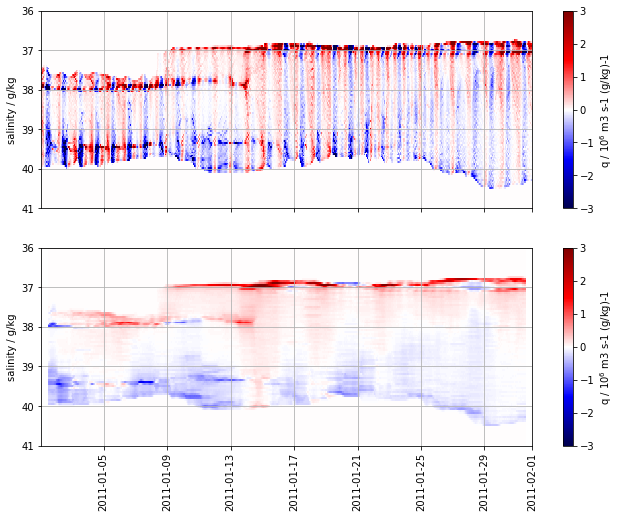

In [8]:
fig, ax = plt.subplots(2,1,sharex=True,sharey=False,figsize=(11,8))
ax=ax.ravel()
vmax=3.0
#out1d_vol_transport_s.q.plot()
pcol=ax[0].pcolormesh(out1d_vol_transport_s.time,out1d_vol_transport_s.var_q,out1d_vol_transport_s.q.T/1000000,
                 cmap='seismic',vmin=-vmax,vmax=vmax)
ax[0].set_ylim(41,36) #invert salinity axis
ax[0].set_ylabel('salinity / g/kg')
ax[0].grid()
plt.colorbar(pcol,ax=ax[0],label='q / 10$^6$ m3 s-1 (g/kg)-1')

vmax=3.0
pcol=ax[1].pcolormesh(out1d_vol_transport_s.time,out1d_vol_transport_s.var_q,
                      out1d_vol_transport_s.q.rolling(time=24,center=True).mean().T/1000000,
                      cmap='seismic',vmin=-vmax,vmax=vmax)
ax[1].set_ylabel('salinity / g/kg')
ax[1].grid()
ax[1].set_ylim(41,36)
plt.xticks(rotation=90)
plt.colorbar(pcol,ax=ax[1],label='q / 10$^6$ m3 s-1 (g/kg)-1')

One can nicely see the variability of the exchange flow: The range in salinity changes, e.g. around January 9th Indian Ocean Surface Water with salinity 37 arrives again at the transect. 
In addition, a clear tidal signal is present, i.e., inflow and outflow are alternating. When smoothing, by applying a window mean of 24 hours (bottom panel) the diurnal tides are filtered out and variability on larger time scales is more distinctly seen, e.g., the period of ~4 days.

Let's now compute the time series of bulk values:

In [9]:
bulk_vol_s = tef.calc_bulk_values(out1d_vol_transport_s.var_Q,out1d_vol_transport_s.Q)
#bulk_vol_t = tef.calc_bulk_values(out1d_vol_transport_t.var_Q,out1d_vol_transport_t.Q)
#bulk_salt_s = tef.calc_bulk_values(out1d_salt_transport_s.var_Q,out1d_salt_transport_s.Q)
bulk_salt_s = tef.calc_bulk_values(out1d_salt_transport_s.var_Q,out1d_salt_transport_s.Q,index=bulk_vol_s.index)
#bulk_temp_t = tef.calc_bulk_values(out1d_temp_transport_t.var_Q,out1d_temp_transport_t.Q)
print(bulk_vol_s)

<xarray.Dataset>
Dimensions:  (m: 10, n: 10, o: 11, time: 744)
Coordinates:
  * time     (time) datetime64[ns] 2011-01-01T01:00:00 ... 2011-02-01
  * m        (m) int64 0 1 2 3 4 5 6 7 8 9
  * n        (n) int64 0 1 2 3 4 5 6 7 8 9
  * o        (o) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    Qin      (time, m) float64 1.193e+06 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Qout     (time, n) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    divval   (time, o) float64 37.5 40.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    index    (time, o) int64 30 80 0 0 0 0 0 0 0 0 0 ... 66 86 0 0 0 0 0 0 0 0


For the monthly mean bulk values, we have seen that the exchange flow is following a two-layer exchange in both T and S. But on hourly scales we find some cases, where there is more than one inflow and/or more than one outflow (strongly depending on Q_thresh). We further find cases, where there is no inflow or no outflow due to the tides.

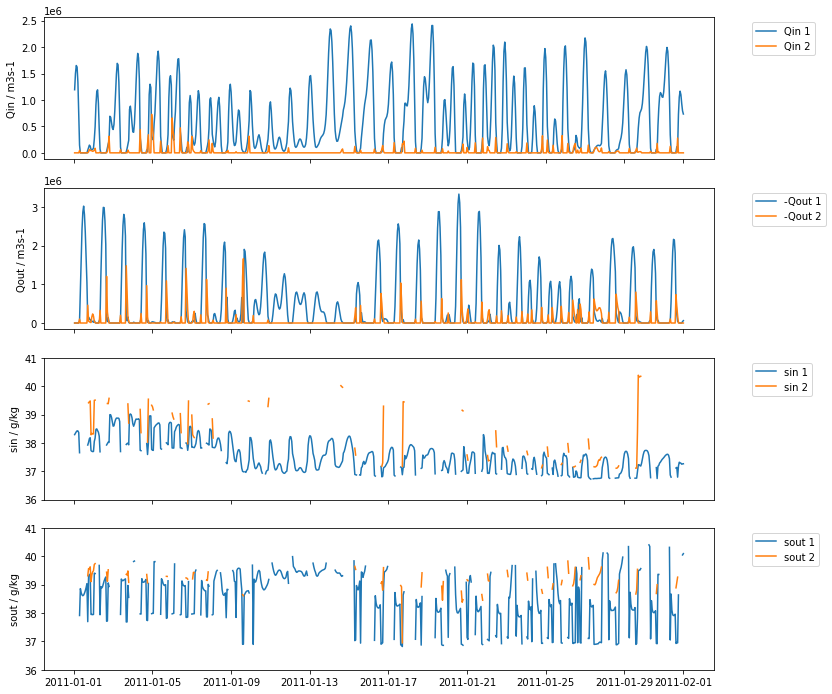

In [10]:
s_in  = bulk_salt_s.Qin / bulk_vol_s.Qin
s_out = bulk_salt_s.Qout / bulk_vol_s.Qout

fig,ax = plt.subplots(4,1,figsize=(12,12),sharex=True)
for i in range(2):
    ax[0].plot(bulk_vol_s.time,bulk_vol_s.Qin[:,i],label='Qin '+str(i+1))
    ax[1].plot(bulk_vol_s.time,-bulk_vol_s.Qout[:,i],label='-Qout '+str(i+1))
    ax[2].plot(bulk_vol_s.time,s_in[:,i],label='sin '+str(i+1))
    ax[3].plot(bulk_vol_s.time,s_out[:,i],label='sout '+str(i+1))

ax[0].legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax[1].legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax[2].legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax[3].legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax[0].set_ylabel('Qin / m3s-1')
ax[1].set_ylabel('Qout / m3s-1')
ax[2].set_ylabel('sin / g/kg')
ax[3].set_ylabel('sout / g/kg')

ax[2].set_ylim(36,41)
ax[3].set_ylim(36,41)

plt.show()

To combine the multilayer bulk values to one value, one can simply sum over the second axis:

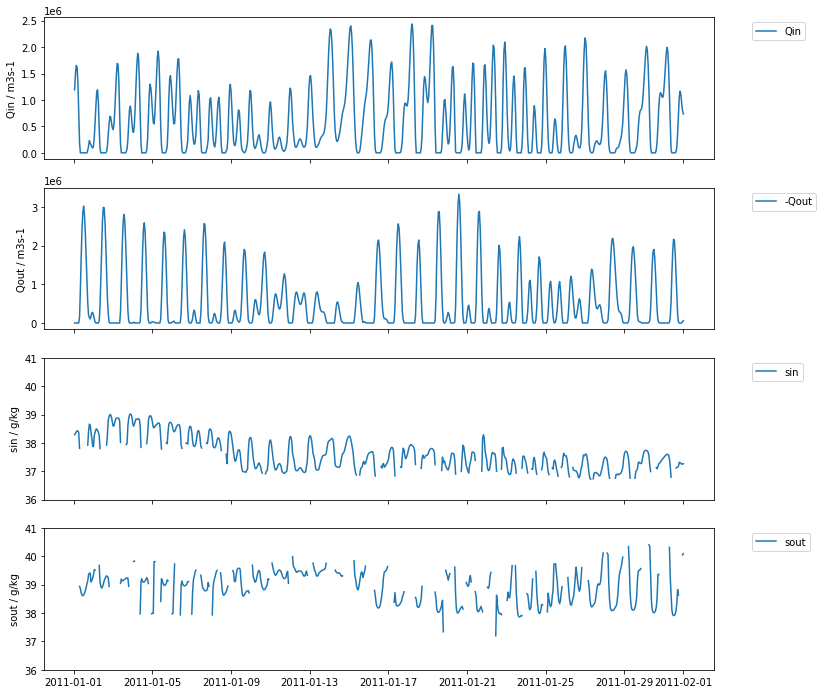

In [11]:
Q_in = bulk_vol_s.Qin.sum(axis=1)
Qs_in = bulk_salt_s.Qin.sum(axis=1)
Q_out = bulk_vol_s.Qout.sum(axis=1)
Qs_out = bulk_salt_s.Qout.sum(axis=1)

s_in = Qs_in / Q_in
s_out= Qs_out / Q_out

fig,ax = plt.subplots(4,1,figsize=(12,12),sharex=True)
ax[0].plot(bulk_vol_s.time,Q_in,label='Qin')
ax[1].plot(bulk_vol_s.time,-Q_out,label='-Qout')
ax[2].plot(bulk_vol_s.time,s_in,label='sin')
ax[3].plot(bulk_vol_s.time,s_out,label='sout')

ax[0].legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax[1].legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax[2].legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax[3].legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax[0].set_ylabel('Qin / m3s-1')
ax[1].set_ylabel('Qout / m3s-1')
ax[2].set_ylabel('sin / g/kg')
ax[3].set_ylabel('sout / g/kg')

ax[2].set_ylim(36,41)
ax[3].set_ylim(36,41)

plt.show()

Yet, this still has a lot of missing 0 included since the dirnal tides are so strong. One **must not** smooth the bulk values, but has to smooth Q and compute the bulk values again from the smooth Q! We do this again by using the rolling function of xarray.

In [14]:
bulk_vol_s = tef.calc_bulk_values(out1d_vol_transport_s.var_Q,
                                  out1d_vol_transport_s.Q.rolling(time=24,center=True).mean(),Q_thresh=10000.0)
#bulk_vol_t = tef.calc_bulk_values(out1d_vol_transport_t.var_Q,out1d_vol_transport_t.Q)
bulk_salt_s = tef.calc_bulk_values(out1d_salt_transport_s.var_Q,
                                   out1d_salt_transport_s.Q.rolling(time=24,center=True).mean(),index=bulk_vol_s.index)

/silos/conda_packages/lorenz/miniconda3_4.8.2/OS_42.3/conda_env/iow_python/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


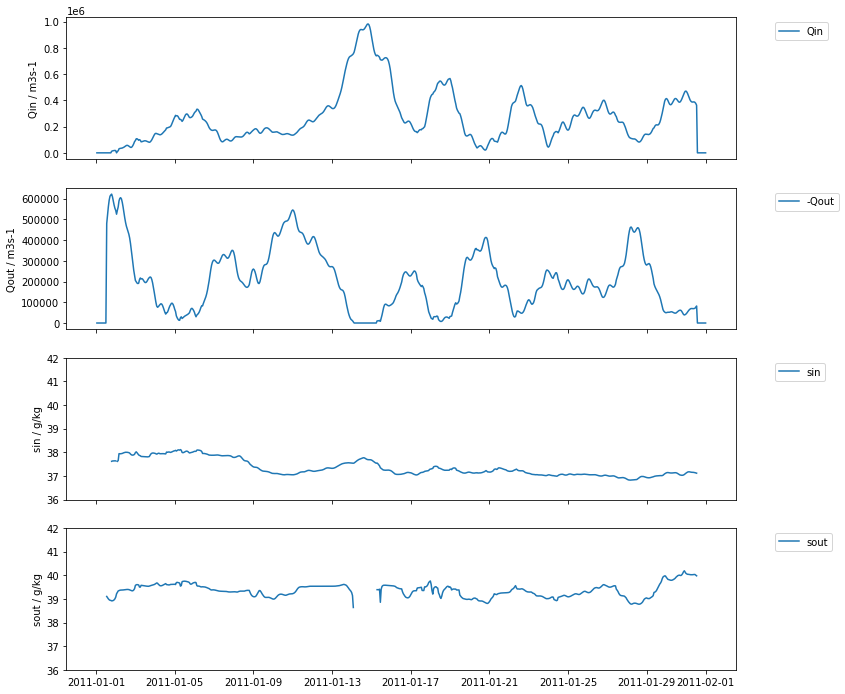

In [15]:
Q_in = bulk_vol_s.Qin.sum(axis=1)
Qs_in = bulk_salt_s.Qin.sum(axis=1)
Q_out = bulk_vol_s.Qout.sum(axis=1)
Qs_out = bulk_salt_s.Qout.sum(axis=1)

s_in = Qs_in / Q_in
s_out= Qs_out / Q_out

fig,ax = plt.subplots(4,1,figsize=(12,12),sharex=True)
ax[0].plot(bulk_vol_s.time,Q_in,label='Qin')
ax[1].plot(bulk_vol_s.time,-Q_out,label='-Qout')
ax[2].plot(bulk_vol_s.time,s_in,label='sin')
ax[3].plot(bulk_vol_s.time,s_out,label='sout')

ax[0].legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax[1].legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax[2].legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax[3].legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax[0].set_ylabel('Qin / m3s-1')
ax[1].set_ylabel('Qout / m3s-1')
ax[2].set_ylabel('sin / g/kg')
ax[3].set_ylabel('sout / g/kg')

ax[2].set_ylim(36,42)
ax[3].set_ylim(36,42)

plt.show()

Filtering out the diurnal tides, one can more clearly see the signals of larger time scales. Still, there is a period of no outflow, which corresponds to a very large inflow.